In [1]:
import os
import glob
import time

import numpy as np
import pandas as pd
#IPython.display for audio output
import IPython.display as ipd
# Librosa for audio
import librosa
import librosa.display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# For designing the band-pass filter
from scipy.signal import butter, lfilter, hilbert

import matplotlib.pyplot as plt
import matplotlib.style as ms
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# HEADS UP: modify the path according to your local machine
train_path_em = '/home/xukecheng/Desktop/cleaned_data/train_balanced/Emergency/'
train_path_nonem = '/home/xukecheng/Desktop/cleaned_data/train_balanced/nonEmergency/'

test_path_em = '/home/xukecheng/Desktop/cleaned_data/eval_balanced/Emergency/'
test_path_nonem = '/home/xukecheng/Desktop/cleaned_data/eval_balanced/nonEmergency/'

In [3]:
def butter_bandpass_filter(data, lowcut=500, highcut=1500, fs=8000, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

### Use librosa.load to load audio time series data

In [19]:
fn = os.path.join(train_path_em, '101.wav')
y, sr = librosa.load(fn, sr=8000)
ipd.Audio(fn)

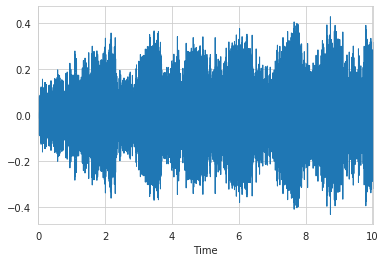

In [5]:
librosa.display.waveplot(y=y, sr=sr);

In [6]:
print(y.shape)

(80214,)


### Apply butter bandpass filter on audio time series data

In [7]:
y_filt = butter_bandpass_filter(y)
print(y_filt.shape)

(80214,)


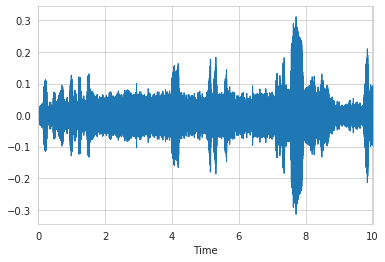

In [8]:
librosa.display.waveplot(y=y_filt, sr=sr)

In [9]:
def melspectrogram(y,sr):
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)
    
    return log_S

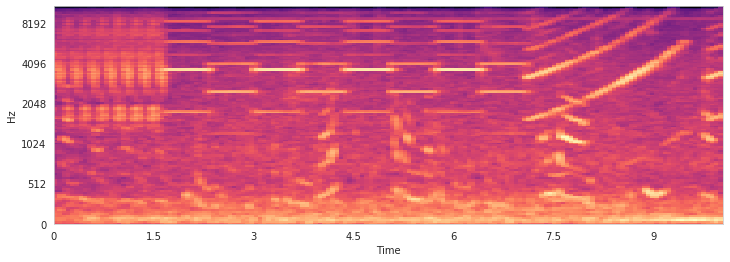

In [10]:
log_S = melspectrogram(y,sr)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel');

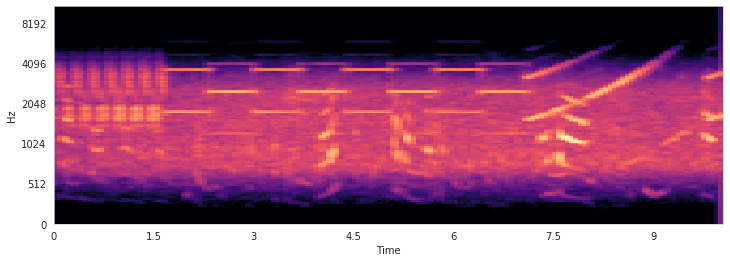

In [11]:
log_S = melspectrogram(y_filt,sr)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel');

In [12]:
print(log_S.shape)

(128, 157)


In [13]:
analytic_signal = hilbert(y_filt)
amplitude_envelope = np.abs(analytic_signal)

/home/xukecheng/.local/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


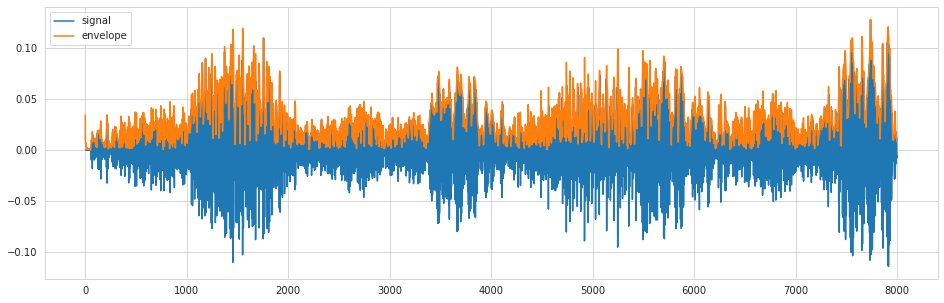

In [14]:
t = np.arange(len(y[:8000])) / sr
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_subplot(111)
# ax0.plot(y[:8000], label='signal')
ax0.plot(analytic_signal[:8000], label='signal')
ax0.plot(amplitude_envelope[:8000], label='envelope')
ax0.legend();

## Feature Extraction

In [15]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

In [16]:
def preprocess(y):
    y_filt = butter_bandpass_filter(y)
    analytic_signal = hilbert(y_filt)
    amplitude_envelope = np.abs(analytic_signal)
    return amplitude_envelope

In [17]:
# Read all the files from the dataset folder
em_files = glob.glob(os.path.join(train_path_em, '*.wav'))
nonem_files = glob.glob(os.path.join(train_path_nonem, '*.wav'))

In [18]:
X_em = []
for fn in tqdm(em_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr)
    X_em.extend(features)

  0%|          | 0/123 [00:00<?, ?it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
100%|██████████| 123/123 [02:52<00:00,  1.41s/it]


In [20]:
len(X_em)

20924

In [21]:
len(X_em[0])

74

In [22]:
X_em[0]

array([ 1.02628285e-01,  2.46655142e-02,  3.31548746e+00,  1.67567851e-01,
        1.59276505e-01,  1.14783430e+00,  0.00000000e+00,  1.95000000e-01,
       -2.30217660e+01,  3.40379436e+00, -1.38264871e+00,  5.03298354e-02,
       -8.35830573e-02, -5.66102725e-02, -2.88322912e-01,  1.48695405e-01,
        2.54489996e-01,  7.88218661e-02, -2.43362463e-02,  1.24508475e-03,
        2.54641113e-01,  2.95417019e-03,  3.07955687e-03,  3.38926974e-03,
        5.99520387e-03,  4.08061247e-03,  3.96812370e-03,  4.27436772e-03,
        1.53410617e-03,  7.24459730e-03,  4.33716743e-03,  6.67729383e-02,
        2.11704493e-03,  1.74388471e-02,  9.99997073e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.99990984e-01,  3.72178166e-03,
        6.10064067e-02,  1.48871266e-02,  2.49995018e-01,  1.59109950e-01,
        3.98885885e-01,  8.12050124e-01,  1.42856337e-01,  4.02536070e-02,
        2.00633016e-01,  7.78425896e-01,  7.69229089e-02,  1.98514122e-02,
        1.40895040e-01,  

In [23]:
count = 0
X_nonem = []
for fn in tqdm(nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr);
    X_nonem.extend(features)
    count += 1
    if count == 120:
        break

  7%|▋         | 119/1667 [03:33<31:08,  1.21s/it]  

In [24]:
len(X_nonem)

23061

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def prepare_data(X_em, X_nonem):
    X_em = np.array(X_em)
    X_nonem = np.array(X_nonem)
    
    X = np.vstack((X_em, X_nonem))
    Y = np.hstack((np.ones(len(X_em)), np.zeros(len(X_nonem))))
    
    scaler = StandardScaler()
    scaler.fit_transform(X)
    
    X, Y = shuffle(X, Y, random_state=7)
    
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    return X, Y, scaler

In [26]:
X_train, Y_train, scaler1 = prepare_data(X_em, X_nonem)

In [27]:
f= open("scaler_values.txt","w+")
mean_v = []
std_v = []
for i in range(len(scaler1.mean_)):
    mean_v.append(scaler1.mean_[i])
    std_v.append(scaler1.scale_[i])
f.write("scaler mean:\n{}".format(mean_v))
f.write("\nscaler std:\n{}".format(std_v))
f.close()

In [28]:
test_em_files = glob.glob(os.path.join(test_path_em, '*.wav'))
test_nonem_files = glob.glob(os.path.join(test_path_nonem, '*.wav'))

In [29]:
X_test_em = []
for fn in tqdm(test_em_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr);
    X_test_em.extend(features)


  0%|          | 0/134 [00:00<?, ?it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))

100%|██████████| 134/134 [03:00<00:00,  1.34s/it]


In [30]:
X_test_nonem = []
for fn in tqdm(test_nonem_files):
    y, sr = librosa.load(fn, sr=8000)
    y = preprocess(y)
    features = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr);
    X_test_nonem.extend(features)


100%|██████████| 105/105 [02:31<00:00,  1.45s/it]


In [31]:
X_test, Y_test, scaler2 = prepare_data(X_test_em, X_test_nonem)

In [105]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras import optimizers
import tensorflow as tf
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
np.random.seed(7)

# Supress Tensorflow error logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [106]:
model = Sequential()
model.add(Dense(74, input_dim=74, activation='relu'))
model.add(Dense(16, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 74)                5550      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                1200      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 6,767
Trainable params: 6,767
Non-trainable params: 0
_________________________________________________________________


In [107]:
optm = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=optm, metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=0, mode='auto')
callbacks_list = [earlystop]

In [108]:
history = model.fit(X_train, Y_train, epochs=200, validation_data=(X_test, Y_test), batch_size=256, callbacks=callbacks_list)
model.save("model_3h.h5")
print("Saved model to disk!")

Train on 43985 samples, validate on 42101 samples
Epoch 1/200
43985/43985 [==============================] - 2s 45us/step - loss: 0.6027 - acc: 0.6889 - val_loss: 0.5701 - val_acc: 0.7131
Epoch 2/200
43985/43985 [==============================] - 1s 29us/step - loss: 0.4695 - acc: 0.7927 - val_loss: 0.5217 - val_acc: 0.7573
Epoch 3/200
43985/43985 [==============================] - 1s 30us/step - loss: 0.4241 - acc: 0.8188 - val_loss: 0.4966 - val_acc: 0.7748
Epoch 4/200
43985/43985 [==============================] - 1s 29us/step - loss: 0.4044 - acc: 0.8273 - val_loss: 0.5028 - val_acc: 0.7701
Epoch 5/200
43985/43985 [==============================] - 1s 29us/step - loss: 0.3922 - acc: 0.8311 - val_loss: 0.4976 - val_acc: 0.7705
Epoch 6/200
43985/43985 [==============================] - 1s 29us/step - loss: 0.3790 - acc: 0.8375 - val_loss: 0.4922 - val_acc: 0.7799
Epoch 7/200
43985/43985 [==============================] - 1s 30us/step - loss: 0.3754 - acc: 0.8362 - val_loss: 0.5069 - 

In [64]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('model_history.png')

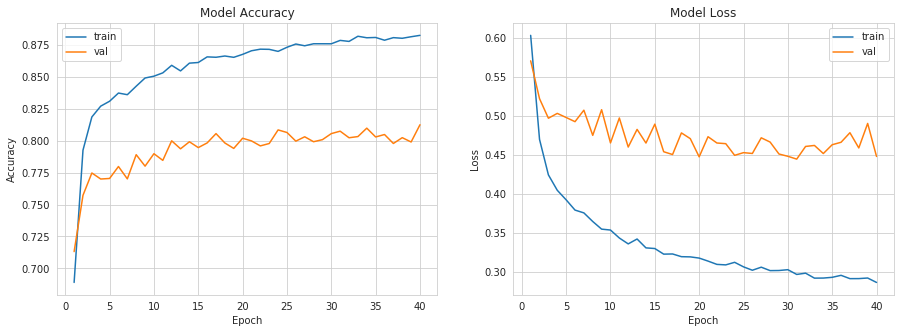

In [109]:
plot_model_history(history)

In [110]:
model = load_model('model_3h.h5')

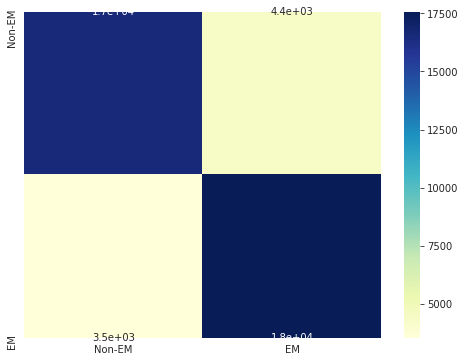

In [111]:
Y_pred = model.predict_classes(X_test)
cm = confusion_matrix(Y_pred, Y_test)
df_cm = pd.DataFrame(cm, index = ['Non-EM', 'EM'],
                  columns = ['Non-EM', 'EM'])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True, cmap='YlGnBu');

In [117]:
pred_test = np.array(model.predict_classes(X_test))
pred_test = pred_test[:, 0]
pred_test

Y_test_np = np.array(Y_test)
Y_test_em = Y_test_np[Y_test_np==1]
Y_test_nonem = Y_test_np[Y_test_np==0]

is_correct = pred_test == Y_test_np
print(np.sum(is_correct) / is_correct.shape[0])

em_correct = is_correct[Y_test_np == 1]
print(np.sum(em_correct) / em_correct.shape[0])

nonem_correct = is_correct[Y_test_np == 0]
print(np.sum(nonem_correct) / nonem_correct.shape[0])

0.8126647823092088
0.8015507411630559
0.8247422680412371


In [112]:
def predict_op(y, scaler):
    y = preprocess(y)
    features_list = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr)
    scaler.transform(features_list)
    count = 0
    N = 10
    th = 0.5
    
    prob_list = []
    class_list = []
    for i in range(N):
        p = model.predict(features_list[i].reshape(1,74), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
    prob = np.mean(prob_list)
    #print(prob)
    if prob > th:
        #print("Em")
        class_list.append(1)
    else:
        #print("Non-em")
        class_list.append(0)
    
    for i in range(N,len(features_list)):
        prob_list.pop(0)
        p = model.predict(features_list[i].reshape(1,74), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
        prob = np.mean(prob_list)
        #print(prob)
        if prob > th:
            #print("Em")
            class_list.append(1)
        else:
            #print("Non-em")
            class_list.append(0)
    if np.mean(class_list) > 0.5:
        return 1
    else:
        return 0

In [114]:
tot = 0
correct_em = 0
op_list = []
for test_file in tqdm(test_em_files):
    y, sr = librosa.load(test_file, sr=8000)
    classes = predict_op(y, scaler2)
    if classes == 1:
        correct_em += 1
    tot += 1

print(correct_em)
print(tot)




  0%|          | 0/134 [00:00<?, ?it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



  1%|          | 1/134 [00:00<02:06,  1.05it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



  1%|▏         | 2/134 [00:01<02:03,  1.07it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



  2%|▏         | 3/134 [00:02<02:00,  1.09it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too




 22%|██▏       | 29/134 [01:17<05:08,  2.94s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 22%|██▏       | 30/134 [01:18<04:00,  2.31s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 23%|██▎       | 31/134 [01:23<05:10,  3.01s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 24%|██▍       | 32/134 [01:24<04:02,  2.38s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value 




 43%|████▎     | 58/134 [01:58<02:04,  1.64s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 44%|████▍     | 59/134 [02:02<02:40,  2.14s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 45%|████▍     | 60/134 [02:03<02:10,  1.76s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 46%|████▌     | 61/134 [02:07<03:11,  2.62s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value 




 65%|██████▍   | 87/134 [02:34<00:31,  1.48it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 66%|██████▌   | 88/134 [02:34<00:24,  1.90it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 66%|██████▋   | 89/134 [02:35<00:32,  1.38it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 67%|██████▋   | 90/134 [02:35<00:26,  1.65it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value 




 87%|████████▋ | 116/134 [03:02<00:13,  1.34it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 87%|████████▋ | 117/134 [03:02<00:10,  1.58it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 88%|████████▊ | 118/134 [03:03<00:11,  1.43it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 89%|████████▉ | 119/134 [03:05<00:14,  1.01it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level va

118
134


In [115]:
correct_em

118

In [116]:
tot

134

In [ ]:
tot = 0
correct_nonem = 0
op_list = []
for test_file in tqdm(test_nonem_files):
    y, sr = librosa.load(test_file, sr=8000)
    classes = predict_op(y, scaler2)
    if classes == 0:
        correct_nonem += 1
    tot += 1




  0%|          | 0/105 [00:00<?, ?it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



  1%|          | 1/105 [00:01<01:47,  1.03s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



  2%|▏         | 2/105 [00:01<01:41,  1.01it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



  3%|▎         | 3/105 [00:02<01:37,  1.05it/s]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too




 28%|██▊       | 29/105 [00:37<02:21,  1.87s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 29%|██▊       | 30/105 [00:37<01:57,  1.56s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 30%|██▉       | 31/105 [00:38<01:41,  1.37s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 30%|███       | 32/105 [00:39<01:30,  1.24s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value 




 55%|█████▌    | 58/105 [01:26<00:54,  1.15s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 56%|█████▌    | 59/105 [01:27<00:59,  1.30s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 57%|█████▋    | 60/105 [01:29<00:57,  1.27s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))



 58%|█████▊    | 61/105 [01:30<00:52,  1.18s/it]/home/xukecheng/anaconda3/envs/fuel-py36/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value 




 83%|████████▎ | 87/105 [02:27<00:19,  1.06s/it]

In [ ]:
tot

In [ ]:
correct_nonem

In [ ]:
test_file = os.path.join(test_path_em, '101.wav')
y, sr = librosa.load(test_file, sr=8000)
ipd.Audio(test_file)

FP: 104 (bicycle bell)  
FN: 12 (clear siren), 15 (vehicle noise)

In [ ]:
def predict_prob(y, scaler):
    y = preprocess(y)
    mfccs_list = audioFeatureExtraction.stFeatureExtraction(y, sr, 0.10*sr, .05*sr)
    scaler.transform(mfccs_list)
    count = 0
    N = 20
    th = 0.5
    
    model = load_model('model_3h.h5')
    
    prob_list = []
    class_list = []
    for i in range(N):
        p = model.predict(mfccs_list[i].reshape(1,74), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
    prob = np.mean(prob_list)
    #print(prob)
    if prob > th:
        #print("Em")
        class_list.append(1)
    else:
        #print("Non-em")
        class_list.append(0)
    
    for i in range(N,len(mfccs_list)):
        prob_list.pop(0)
        p = model.predict(mfccs_list[i].reshape(1,74), batch_size=None, verbose=0)
        p = p.flatten()
        prob_list.append(p)
        prob = np.mean(prob_list)
        #print(prob)
        if prob > th:
            #print("Em")
            class_list.append(1)
        else:
            #print("Non-em")
            class_list.append(0)
    return class_list

In [ ]:
classes = predict_prob(y, scaler2)

In [ ]:
plt.figure()
plt.plot(classes, c='r', linewidth = 3.0, alpha=0.5)
plt.yticks([0,1])
plt.ylim([-0.1,1.1])
plt.xlabel("Samples")
plt.ylabel("Em signal presence")
plt.grid('on')
plt.show()

In [ ]:
log_S = melspectrogram(y,sr)
# Make a new figure
plt.figure(figsize=(12,4))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel');